# 21M.387 Fundamentals of Music Processing
## Lab7

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp
from fmplib.pyqueue import connect_to_queue

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['image.interpolation'] = 'nearest'

fmp.documentation_button()

## Exercise 1

Find a song - ideally 3-5 minutes in length and using Audacity, save it as a 22050Hz, mono wave file.

Using [Sonic Visualizer](https://www.sonicvisualiser.org/), add markers to the song at the locations that you consider to be section boundaries:
- Open the wave file.
- Play it.
- Each time you get to a section boundary, hit `;` to add a new "Time Instance Marker".
- Drag the time line with the navigate tool <img style="display: inline-block;
" src='images/sv_navigate.png'> to move around the audio
- You can refine markers by using the edit tool <img style="display: inline-block;
" src='images/sv_edit.png'>
- You can also view and edit markers with `E` to view the layer data.
- Export Annotation Layer (from the File Menu) as a text file with settings:
  - Column Separator: Tab
  - Timing Format: Seconds
  - Range to Export: full duration

<img src='images/sv_export.png'>


In [ ]:
connect_to_queue()

## Exercise 2

- Load the song file into the variable `snd`
- Load the annotations using `load_annotiations(filename)` into the variable `ref` for reference annotation.


In [2]:
def load_annotations(filepath) :
    lines = open(filepath).readlines()
    return np.array([float(l.split('\t')[0]) for l in lines])

In [5]:
snd = fmp.load_wav("audio/khruangbin-august_10.wav")
ref = load_annotations("data/khruangbin-august_10.csv")

print(ref)

[ 13.3014966   24.98371882  36.63129252  48.28789116  59.92580499
  71.19124717  82.41578231  89.48970522  94.99038549 106.71664399
 118.55972789 130.27160998 141.11922903 152.87201814 164.43138322
 175.80902494 187.33555556 199.85591837 211.55968254 223.20780045
 234.92185941 246.6399093 ]


In [ ]:
connect_to_queue()

## Exercise 3

Write the function `audio_to_ssm()` that converts the audio into a self-similarity matrix

Inputs: 
- `snd`: the audio
- `cens_filt_len`: $l$, the CENS filter length
- `cens_ds`: $d$, CENS downsample factor

Outputs:
- A tuple of the SSM $\mathbf{S}$ and the feature rate $F_f$

Strategy:
- Create a regular chromagram using `fmp.make_chromagram` using $N = 4096$, $H = 2048$, $F_s = 22050$.
- Use `fmp.cens(chroma, cens_filt_len, cens_ds)` to create a CENS chromagram with window filter length $l$ and downsample factor $d$.
- Create $\mathbf{S}$, the self-similarity matrix from this chromagram.

In [38]:
def audio_to_ssm(snd, cens_filt_len, cens_ds):
    fft_len = 4096
    hop_size = fft_len // 2
    fs = 22050
    
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size)
    chroma = fmp.cens(chroma, cens_filt_len, cens_ds)
    
    ff = fs / hop_size / cens_ds
    ssm = np.dot(chroma.T, chroma)

    return ssm, ff

- Call this function for the song you just loaded using CENS parameters $l=40, d=3$. 
- Print the feature rate.
- Plot the SSM.
- Try a few other CENS parameters to see how the resulting SSM changes.

ff=3.5888671875


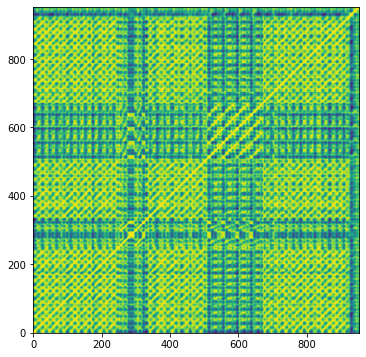

In [42]:
cens_filt_len = 40
cens_ds = 3
ssm, ff = audio_to_ssm(snd, cens_filt_len, cens_ds)

print(f'ff={ff}')

# plot
plt.figure(figsize=(10,6))
plt.imshow(ssm, origin='lower');

In [ ]:
connect_to_queue()

## Exercise 4a

Write the function `make_binary_checkerboard()` to generate a binary checkerboard kernel $\mathbf{K}_B$. This is a $M \times M$ square matrix composed of four $L \times L$ regions where $L = \frac M 2$. The two regions on the main diagonal have value $1$ while the two other regions are $-1$. 

Inputs:
- `cb_len`: $M$, the full dimension of the checkerboard kernel

Output:
- an $M \times M$ binary checkerboard kernel matrix


In [50]:
def make_binary_checkerboard(cb_len):
    m = np.ones((cb_len // 2, cb_len // 2))
    m = np.hstack([m, m * -1])
    m = np.vstack([m, m * -1])
    
    return m

Create and plot this checkerboard for $M=40$. What is the length of $\mathbf{K}_B$ in seconds?

length in secs = 11.15


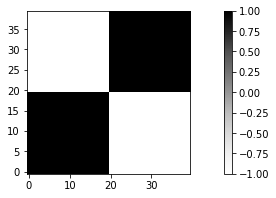

In [59]:
cb_len = 40
cb = make_binary_checkerboard(cb_len)

print(f'length in secs = {cb_len / ff:.2f}')

plt.figure(figsize = (12,3))
plt.imshow(cb, origin='lower', cmap='Greys');
plt.colorbar();

## Exercise 4b

You can smooth the edges of $\mathbf{K}_B$ by doing a point-by-point multiplication with a 2-dimensional Gaussian matrix. `fmp.make_2d_gaussian(wlen, eps)` creates a radially symmetric Gaussian function $\mathbf{G}$ where parameter $\epsilon$ controls the degree of tapering.

Write the function `make_checkerboard()` that creates a tapered checkerboard kernel $\mathbf{K}_{G} = \mathbf{G} \odot \mathbf{K}_B$ ($\odot$ means element-wise multiplication).

Inputs:
- `cb_len`: $M$, the full dimension of the checkerboard kernel
- `eps`: $\epsilon$, the Gaussian tapering parameter

Output:
- an $M \times M$ Gaussian smoothed checkerboard kernel matrix

Create and plot $\mathbf{K}_{G}$ with $M = 40$ and $\epsilon = 1$

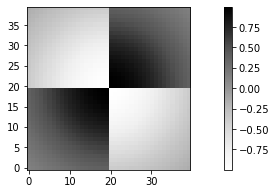

In [79]:
def make_checkerboard(cb_len, eps):
    cb = make_binary_checkerboard(cb_len)
    w = fmp.make_2d_gaussian(cb_len, eps)
    
    return cb * w


cb = make_checkerboard(cb_len, 1)
plt.figure(figsize = (12,3))
plt.imshow(cb, origin='lower', cmap='Greys');
plt.colorbar()
plt.show()

In [ ]:
connect_to_queue()

## Exercise 5a

To find boundary locations, slide $\mathbf{K}_{G}$ along the main diagonal of $\mathbf{S}$, summing the element-wise product of $\mathbf{K}_{G}$ and $\mathbf{S}$ where they overlap. This produces the boundary novelty function $\Delta_K[n]$:

$$\Delta_K[n] =  \sum_{k,l \in [-L:L-1]} \mathbf{K}[k, l] \mathbf{S}[n+k, n+l] $$

Write the function `diagonal_slide()` which produces $\Delta_K[n]$.

Inputs:
- `ssm`: $\mathbf{S}$, the self-similarity matrix
- `kernel`:  $\mathbf{K}_{G}$, the checkerboard kernel 

Ouput:
- $\Delta_K[n]$

The easiest way to handle areas where $\mathbf{K}_{G}$ does not overlap $\mathbf{S}$ is to zero-pad $\mathbf{S}$ with $L = \frac M 2$ zeros on all sides.



Plot $\Delta_K[n]$.

In [152]:
def diagonal_slide(ssm, kernel):
    M = kernel.shape[0]
    m = np.pad(ssm, M // 2)
    nov = np.zeros(ssm.shape[0])
    
    for n in range(ssm.shape[0]):
        nov[n] = np.sum(kernel * m[n:n+M,n:n+M])
    
    return nov

To check your answer, the curve you get for $\Delta_K[n]$ should be the same as this:

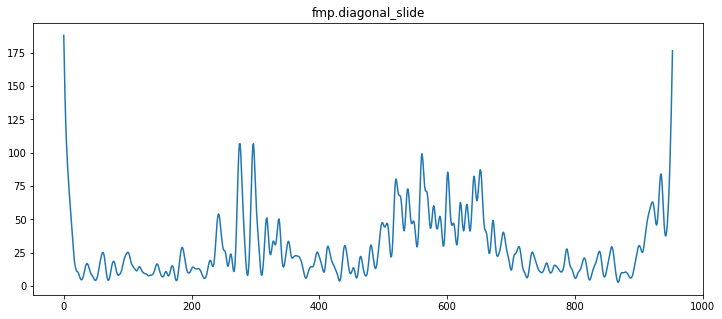

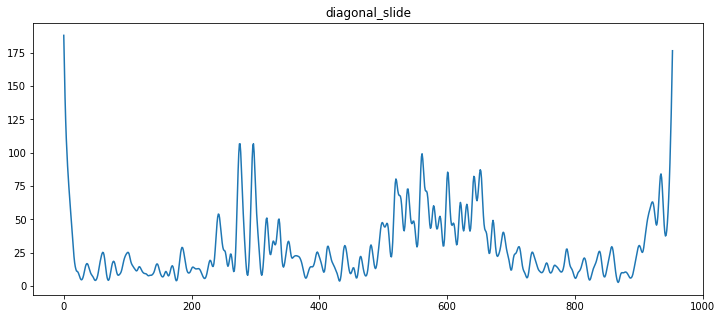

In [154]:
plt.plot(fmp.diagonal_slide(ssm, fmp.make_checkerboard(40, True, False)))
plt.title('fmp.diagonal_slide')
plt.show()

nov = diagonal_slide(ssm, cb)
plt.plot(nov)
plt.title('diagonal_slide')
plt.show()

## Exercise 5b

Find the peaks of $\Delta_K[n]$ using `fmp.find_region_peaks(x, region_len)`. This peak finding variant will only return the highest peak within a neighborhood of `region_len` samples around that peak. Use a neighborhood of 15 seconds (but remember that you must convert seconds to samples).

These peaks are the estimates of the boundary locations. Plot the novelty function and the locations of the peaks.

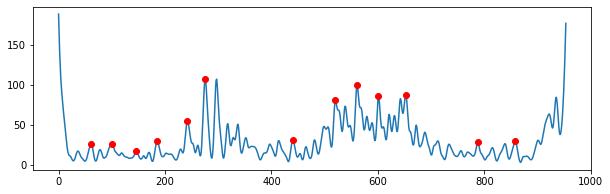

In [172]:
region_len = int(15 * ff)
peaks = fmp.find_region_peaks(nov, region_len)
plt.figure(figsize=(10,3))
plt.plot(nov)
plt.plot(peaks, nov[peaks], 'ro');

In [ ]:
connect_to_queue()

## Exercise 6a

- Convert the reference annotations from Exercise 2 (which are in seconds) to the feature rate of the novelty curve.
- Recreate the plot above (novelty and boundary estimates), and add an additional plot for the reference annotations using `plt.vlines()`.

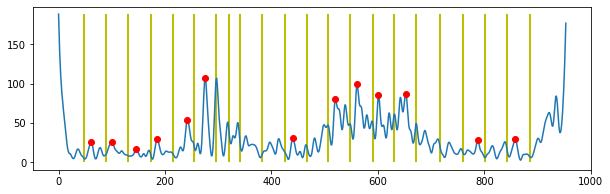

In [173]:
ref_fr = np.array(ref * ff).astype(int)
plt.figure(figsize=(10,3))
plt.plot(nov)
plt.plot(peaks, nov[peaks], 'ro')
plt.vlines(ref_fr, 0, np.max(nov), 'y', linewidth=2)
plt.show()

## Exercise 6b


Use the function `fmp.calc_prf(est, ref, tau)` to calculate the Precision, Recall, and F-measure numbers.

- `est` is the estimate boundary estimates from your algorithm
- `ref` is the reference / ground-truth annotations
- `tau` is the comparison window. 

When comparing an estimated point $b^{\text{Est}}$ and reference point $b^{\text{Ref}}$,
$\vert b^{\text{Est}} - b^{\text{Ref}} \vert < \tau$ indicates a match.

Use $\tau = 3$ seconds. But remember that `tau` must be in the same units as `est` and `ref`.


What values do you get for P, R, and F?

In [177]:
P, R, F = fmp.calc_prf(peaks, ref, int(3 * ff))
print(f'P={P}, R={R}, F={F}')

P=0.38461538461538464, R=0.22727272727272727, F=0.2857142857142857


In [ ]:
connect_to_queue('checkoff')

## Exercise 7

As you wait for the checkoff, try adjusting some of the parameters above and see if you can improve your F-measure results. 

As a reminder, the full set of parameters are:
- `cens_filt_len`
- `cens_ds`
- `cb_len`, (`eps` is not worth modifying)
- `region_len`

Also look at how precision and recall change as you increase and decrease these parameters.

In [193]:
@interact(cens_filt_len=(1, 100, 1),
          cens_ds=(1, 20),
          cb_len=(2,100,2),
          region_secs=(1,30,1))
def test(cens_filt_len=11, cens_ds=9, cb_len=6, region_secs=9):
    ssm, ff = audio_to_ssm(snd, cens_filt_len, cens_ds)
    cb = make_checkerboard(cb_len, 1)
    nov = diagonal_slide(ssm, cb)
    
    # boundary estimates
    region_len = int(region_secs * ff)
    peaks = fmp.find_region_peaks(nov, region_len)
    ref_fr = np.array(ref * ff).astype(int)
    
    plt.figure(figsize=(10,3))
    plt.plot(nov)
    plt.plot(peaks, nov[peaks], 'ro')
    plt.vlines(ref_fr, 0, np.max(nov), 'y', linewidth=2)
    plt.show()
    
    # evaluation
    P, R, F = fmp.calc_prf(peaks, ref, int(3 * ff))
    print(f'P={P}, R={R}, F={F}')    

interactive(children=(IntSlider(value=11, description='cens_filt_len', min=1), IntSlider(value=9, description=…

# 